## libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

#general
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import random
import gc
gc.enable()
pd.set_option('display.max_columns', None) 

# augmentation
import albumentations as A

# deep learning
import timm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR, ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm.notebook import tqdm
tqdm.pandas()

# metrics
from sklearn.metrics import mean_squared_error

## Config

In [ ]:
class Config:
    model_name = "swint_large224"
    data_dir = "shared/tc1proj001/data/"
    model_path = "swin_large_patch4_window7_224"
    model_dir = "."
    img_train_dir = os.path.join(data_dir, "train")
    img_test_dir = os.path.join(data_dir, "test")
    random_seed = 42
    n_epoch = 5
    n_fold = 5
    pretrained = True
    inp_channels = 3
    im_size =  384
    lr = 2e-5
    opt_wd_non_norm_bias = 0.01
    opt_wd_norm_bias = 0
    opt_beta1 = 0.9
    opt_beta2 = 0.99
    opt_eps = 1e-5
    batch_size = 8
    epoch_step_valid = 3
    steps_per_epoch = 62
    num_workers = 8
    out_features = 1
    dropout = 0
    max_lr =2e-5

In [ ]:
def seed_everything(seed=Config.random_seed):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False

seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [7]:
img_train_dir = os.path.join(Config.data_dir, 'train')
def return_imgfilepath(name, folder=img_train_dir):
    path = os.path.join(folder, f'{name}.jpg')
    return path

train_file_path = os.path.join(Config.data_dir, 'train.csv')
train_df = pd.read_csv(train_file_path)

# set image filepath
train_df['file_path'] = train_df['Id'].progress_apply(lambda x: return_imgfilepath(x))
train_df.head()

  0%|          | 0/9912 [00:00<?, ?it/s]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,shared/tc1proj001/data/train/0007de18844b0dbbb...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,shared/tc1proj001/data/train/0009c66b9439883ba...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,shared/tc1proj001/data/train/0013fd999caf9a3ef...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,shared/tc1proj001/data/train/0018df346ac9c1d84...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,shared/tc1proj001/data/train/001dc955e10590d3c...


## StratifiedKFold

<Axes: xlabel='fold'>

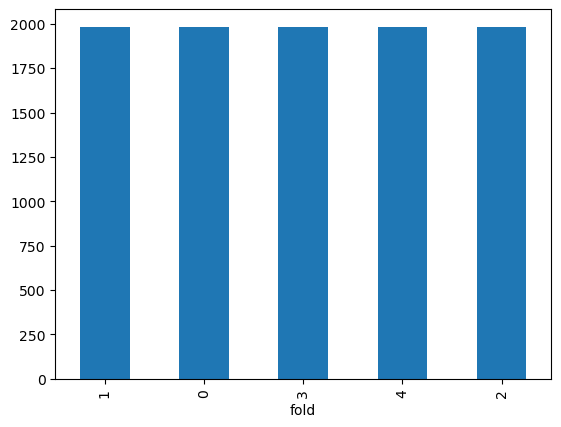

In [8]:
# if Config.is_debug:
#     train_df = train_df.sample(500).reset_index(drop = True)
train_df['norm_score'] = train_df['Pawpularity'] / 100
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['fold'] = -1

skf = StratifiedKFold(n_splits = Config.n_fold, shuffle=True, random_state =Config.random_seed)
for i, (_, train_index) in enumerate(skf.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [9]:
train_df[train_df['fold']==0].head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path,norm_score,bins,fold
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74,shared/tc1proj001/data/train/001dd4f6fafb89061...,0.74,32,0
13,006483b96ca9c09b7afed3e3d3af539d,0,1,1,1,0,0,0,0,1,1,0,0,41,shared/tc1proj001/data/train/006483b96ca9c09b7...,0.41,17,0
29,00b151a572c9aabedf8cfce0fa18be25,0,0,1,1,0,0,0,0,0,0,0,1,21,shared/tc1proj001/data/train/00b151a572c9aabed...,0.21,8,0
46,0126fe11deba78f84fd05cd5f12c5a4b,0,1,1,1,0,0,0,0,0,0,0,0,37,shared/tc1proj001/data/train/0126fe11deba78f84...,0.37,15,0
52,01430d6ae02e79774b651175edd40842,0,1,1,1,0,0,0,1,0,0,1,0,28,shared/tc1proj001/data/train/01430d6ae02e79774...,0.28,11,0


## Dataset & augmentation


In [10]:
class PetDataset(Dataset):
    def __init__(self, image_filepaths, targets, transform=None):
        self.image_filepaths = image_filepaths
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.image_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.image_filepaths[idx]
        with open(image_filepath, 'rb') as f:
            image = Image.open(f)
            image_rgb = image.convert('RGB')
        image = np.array(image_rgb)

        if self.transform is not None:
            image = self.transform(image = image)["image"]
        
        image = image / 255 # convert to 0-1
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        target = self.targets[idx]

        image = torch.tensor(image, dtype = torch.float)
        target = torch.tensor(target, dtype = torch.float)
        return image, target

In [ ]:
def get_train_transforms(epoch, dim = Config.im_size):
    return A.Compose(
        [             
            A.SmallestMaxSize(max_size=dim, p=1.0),
            A.RandomCrop(height=dim, width=dim, p=1.0),
            A.VerticalFlip(p = 0.5),
            A.HorizontalFlip(p = 0.5)
        ]
  )

def get_inference_fixed_transforms(mode=0, dim = Config.im_size):
    if mode == 0: # do not original aspects, colors and angles
        return A.Compose([
                A.SmallestMaxSize(max_size=dim, p=1.0),
                A.CenterCrop(height=dim, width=dim, p=1.0),
            ], p=1.0)

## Model

In [12]:
class PetNet(nn.Module):
    def __init__(
        self,
        model_name = Config.model_path,
        out_features = Config.out_features,
        inp_channels=Config.inp_channels,
        pretrained=Config.pretrained
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3, num_classes=0)
        self.fc1 = nn.Linear(self.model.num_features, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 1)
    
    def get_image_embedding(self, image):
        return self.model(image)

    def forward(self, image):
        output = self.model(image)
        x= self.fc1(output)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Helper function

### divice_norm_bias
Function to divide parameters at so that the norms and bias does not have weight decay 

### usr_rmse_score
Calculate the competition metrics which is rmse

### MetricMonitor
Monitors the training and validation scores during training

In [ ]:
def divice_norm_bias(model): 
    norm_bias_params = []
    non_norm_bias_params = []
    except_wd_layers = ['norm', '.bias']
    for n, p in model.model.named_parameters():
        if any([nd in n for nd in except_wd_layers]):
            norm_bias_params.append(p)
        else:
            non_norm_bias_params.append(p)
    return norm_bias_params, non_norm_bias_params

def usr_rmse_score(output, target):
    y_pred = torch.sigmoid(output).cpu()
    y_pred = y_pred.detach().numpy()*100
    target = target.cpu()*100
    
    return mean_squared_error(target, y_pred, squared=False)

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

## Training loop

- scheduler: OneCycleLR
- optimizer: AdamW
- validate every 62 steps of each epoch

In [ ]:
def valid_fn(y_valid, X_valid_paths, model, criterion, epoch):
    model.eval()
    test_targets = []
    test_preds = []
    valid_dataset = PetDataset(
      image_filepaths = X_valid_paths,
      targets = y_valid,
      transform = get_inference_fixed_transforms()
    )
    valid_loader = DataLoader(
      valid_dataset,
      batch_size = Config.batch_size,
      shuffle = False,
      num_workers = Config.num_workers,
      pin_memory = True
    )
    metric_monitor = MetricMonitor()
    stream = tqdm(valid_loader)
    for i, (images, target) in enumerate(stream, start = 1):
        images = images.to(device, non_blocking = True).float()
        target = target.to(device, non_blocking = True).float().view(-1, 1)
        with torch.no_grad():
            output = model(images)
        loss = criterion(output, target)
        rmse_score = usr_rmse_score(output, target)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('RMSE', rmse_score)
        stream.set_description(f"Epoch: {epoch:02}. Valid. {metric_monitor}")

        targets = (target.detach().cpu().numpy() * 100).ravel().tolist()
        pred = (torch.sigmoid(output).detach().cpu().numpy() * 100).ravel().tolist()

        test_preds.extend(pred)
        test_targets.extend(targets)
    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)
    del valid_loader, valid_dataset, target, output
    gc.collect()
    torch.cuda.empty_cache()
    return test_targets, test_preds

In [ ]:
def training_loop(filepaths, targets):
    skf = StratifiedKFold(n_splits = Config.n_fold, shuffle=True, random_state=Config.random_seed)
    for i_fold, (train_idx, valid_idx) in enumerate(skf.split(filepaths, train_df['bins'])):
        print(f'=== fold {i_fold}: training ===')
        """
        separate train/valid data 
        """
        X_train_paths = filepaths[train_idx]
        y_train = targets[train_idx]
        X_valid_paths = filepaths[valid_idx]
        y_valid = targets[valid_idx]
        valid_ids = ids[valid_idx]
        """
        prepare dataset
        """
        train_dataset = PetDataset(
          image_filepaths = X_train_paths,
          targets = y_train,
          transform = get_train_transforms(0)
        )

        """
        create dataloader
        """
        train_loader = DataLoader(
          train_dataset,
          batch_size = Config.batch_size,
          shuffle = True,
          num_workers = Config.num_workers,
          pin_memory = True
        )

        """
        instantiate model, cost function and optimizer
        """
        model = PetNet()
        model = model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        norm_bias_params, non_norm_bias_params = split_norm_bias(model)
        #print(f"norm bias params: {len(norm_bias_params)}, non norm bias params: {len(non_norm_bias_params)}")
        optimizer = torch.optim.AdamW(
          [
              {'params': norm_bias_params, 'weight_decay': Config.opt_wd_norm_bias},
              {'params': non_norm_bias_params, 'weight_decay': Config.opt_wd_non_norm_bias},
          ],
          betas=(Config.opt_beta1, Config.opt_beta2),
          eps=Config.opt_eps,
          lr = Config.lr,
          amsgrad = False
        )
        scheduler = OneCycleLR(
            optimizer,
            max_lr=Config.max_lr,
            pct_start = 0.25, 
            steps_per_epoch=int(((Config.n_fold - 1) * train_df.shape[0]) / (Config.n_fold * Config.batch_size)) + 1,
            epochs = Config.n_epoch
        )
        """
        train / valid loop
        """
        best_rmse = np.inf
        scaler = GradScaler()
        for epoch in range(1, Config.n_epoch + 1):
            print(f'=== fold:{i_fold} epoch: {epoch}: training ===')
            
            metric_monitor = MetricMonitor()
            stream = tqdm(train_loader)

            for batch_idx, (images, target) in enumerate(stream, start = 1):
                model.train()
                images = images.to(device, non_blocking = True).float()
                target = target.to(device, non_blocking = True).float().view(-1, 1)
                optimizer.zero_grad()
                with autocast(): # mixed precision
                    output = model(images)
                    loss = criterion(output, target)
                rmse_score = usr_rmse_score(output, target)
                metric_monitor.update('Loss', loss.item())
                metric_monitor.update('RMSE', rmse_score)
                stream.set_description(f'Epoch: {epoch:02}. Train. {metric_monitor}')
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
            
                if ( ( ( batch_idx % Config.steps_per_epoch == 0) & (epoch >= Config.epoch_step_valid) ) | ( batch_idx == len(train_loader) ) ):
                    valid_targets, preds = valid_fn(y_valid, X_valid_paths, model, criterion, epoch)
                    valid_rmse = round(mean_squared_error(valid_targets, preds, squared=False), 3)
                    print(f'epoch: {epoch}, batch: {batch_idx}/{len(train_loader)}, valid rmse: {valid_rmse}')

                    if valid_rmse < best_rmse:
                        best_rmse = valid_rmse
                        model_name = Config.model_path
                        torch.save(model.state_dict(), f'{Config.model_dir}/{model_name}_fold{i_fold}.pth')
                        print("saved model.")
        
        del model, output, train_loader, train_dataset
        gc.collect()
        torch.cuda.empty_cache()
        clean()
    return 

In [ ]:
ids = train_df['Id'].values
filepaths = train_df['file_path'].values
targets = train_df['Pawpularity'].values /100

In [ ]:
training_loop(filepaths, targets)

=== fold 0: training ===
=== fold:0 epoch: 1: training ===


  0%|          | 0/1983 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 1, batch: 1983/1983, valid rmse: 18.078
saved model.
=== fold:0 epoch: 2: training ===


  0%|          | 0/1983 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 2, batch: 1983/1983, valid rmse: 18.115
=== fold:0 epoch: 3: training ===


  0%|          | 0/1983 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 62/1983, valid rmse: 17.986
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 124/1983, valid rmse: 18.056


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 186/1983, valid rmse: 18.064


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 248/1983, valid rmse: 18.079


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 310/1983, valid rmse: 18.035


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 372/1983, valid rmse: 18.153


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 434/1983, valid rmse: 17.967
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 496/1983, valid rmse: 17.955
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 558/1983, valid rmse: 18.022


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 620/1983, valid rmse: 18.031


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 682/1983, valid rmse: 17.959


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 744/1983, valid rmse: 18.198


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 806/1983, valid rmse: 18.092


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 868/1983, valid rmse: 17.923
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 930/1983, valid rmse: 18.109


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 992/1983, valid rmse: 18.12


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1054/1983, valid rmse: 17.96


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1116/1983, valid rmse: 18.167


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1178/1983, valid rmse: 17.901
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1240/1983, valid rmse: 17.943


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1302/1983, valid rmse: 18.061


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1364/1983, valid rmse: 17.841
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1426/1983, valid rmse: 17.862


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1488/1983, valid rmse: 17.873


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1550/1983, valid rmse: 17.776
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1612/1983, valid rmse: 17.868


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1674/1983, valid rmse: 17.758
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1736/1983, valid rmse: 17.89


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1798/1983, valid rmse: 17.868


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1860/1983, valid rmse: 17.751
saved model.


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1922/1983, valid rmse: 17.771


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 3, batch: 1983/1983, valid rmse: 17.752
=== fold:0 epoch: 4: training ===


  0%|          | 0/1983 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 62/1983, valid rmse: 17.802


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 124/1983, valid rmse: 17.948


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 186/1983, valid rmse: 17.886


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 248/1983, valid rmse: 17.852


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 310/1983, valid rmse: 17.865


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 372/1983, valid rmse: 17.924


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 434/1983, valid rmse: 17.896


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 496/1983, valid rmse: 17.94


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 558/1983, valid rmse: 17.946


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 620/1983, valid rmse: 17.929


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 682/1983, valid rmse: 17.955


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 744/1983, valid rmse: 17.94


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 806/1983, valid rmse: 17.94


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 868/1983, valid rmse: 17.99


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 930/1983, valid rmse: 17.974


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 992/1983, valid rmse: 17.955


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1054/1983, valid rmse: 17.942


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1116/1983, valid rmse: 17.948


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1178/1983, valid rmse: 17.939


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1240/1983, valid rmse: 17.94


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1302/1983, valid rmse: 17.931


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1364/1983, valid rmse: 17.923


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1426/1983, valid rmse: 17.924


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1488/1983, valid rmse: 17.931


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1550/1983, valid rmse: 17.931


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1612/1983, valid rmse: 17.926


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1674/1983, valid rmse: 17.926


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1736/1983, valid rmse: 17.926


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1798/1983, valid rmse: 17.925


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1860/1983, valid rmse: 17.925


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1922/1983, valid rmse: 17.924


  0%|          | 0/496 [00:00<?, ?it/s]

epoch: 4, batch: 1983/1983, valid rmse: 17.924
=== fold 1: training ===
=== fold:1 epoch: 1: training ===


  0%|          | 0/1983 [00:00<?, ?it/s]

KeyboardInterrupt: 